In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Goal

To test the predictive autoencoder model's ability to discover factors that predict stock returns, as measured by accuracy of its predictions, and compare these factors to those found by more traditional factor analysis.

## Methods
All factor-analysis methods are constrained to find only *linear* combinations of the stocks because nonlinear combinations would be impractical to buy and sell in real life.

Factor-analysis methods to compare:
- PCA
    - Linearity constraint: built in
    - Predictions generated: by regressing 1 step ahead
- Predictive autoencoder
    - Linearity constraint: linear activation functions on encoder side
    - Predictions generated: directly as output
    - Variants:
        - Trained 0 steps ahead
            - In this case the predictions are generated after retraining the decoder side alone to predict N steps ahead. This will force it to generate predictions from the existing factors found by the encoder side.
        - Trained 1 step ahead
        - Trained N steps ahead
        - Trained a variable number of steps ahead (1 to some upper bound)
        - Linear decoder side
        - Nonlinear decoder side

### Data Set
The raw data consists of daily S&P500 records in the form of a single CSV file, one row per stock per day. It includes various metrics of the stock's activity that day but we're only interested in the returns.

In [6]:
# raw = pd.read_csv('./SP500DataSet/dailydata.csv', parse_dates=['date'])
raw = pd.read_csv('./SP500DataSet/monthlydata.csv', parse_dates=['date'])
raw

,PERMNO,date,TICKER,CUSIP,PRC,VOL,RET
0,10057,1990-01-31,AMT,00462610,10.25000,3873.0,-0.048276
1,10057,1990-02-28,AMT,00462610,10.12500,2495.0,-0.012195
2,10057,1990-03-30,AMT,00462610,9.62500,3004.0,-0.049383
3,10057,1990-04-30,AMT,00462610,9.12500,1178.0,-0.041558
4,10057,1990-05-31,AMT,00462610,9.00000,1719.0,-0.013699
...,...,...,...,...,...,...,...
198578,93429,2023-08-31,CBOE,12503M10,149.71001,155105.0,0.075745
198579,93429,2023-09-29,CBOE,12503M10,156.21001,134771.0,0.043417
198580,93429,2023-10-31,CBOE,12503M10,163.89000,165000.0,0.049165
198581,93429,2023-11-30,CBOE,12503M10,182.19000,191395.0,0.115016


To prepare this data for use:
- Verify that all stocks are represented for all dates.
- Reformat with one column per stock. Each row will represent the returns of all stocks on one date.

In [10]:
# Reformat first for ease of verifying stock date ranges
stock_id = 'PERMNO' # unique identifier for a security - may be interchangeable with PERMCO for this purpose but theoretically more likely to be unique

# For performance, don't build dataframe on the fly
# Instantiate a blank one with all rows/columns first and then write to its cells
dates = set()
stocks = set()
for row in raw.iloc:
    dates.add(row['date'])
    stocks.add(row[stock_id])
df = pd.DataFrame(index=pd.DatetimeIndex(data=dates, name='date'), columns=list(stocks)).sort_index()
for row in raw.iloc:
    df.loc[row['date'], row[stock_id]] = row['RET']

In [22]:
# Write out because it takes forever to generate
# TODO on rerunning, don't reprocess raw data unless this file is missing
df.to_csv('./SP500DataSet/reformatted.csv')

In [23]:
df

,34817,14338,20482,49154,65541,71685,86021,67598,59408,34833,...,47079,18411,22509,26607,18420,18421,22517,61428,81910,92157
date,,,,,,,,,,,,,,,,,,,,,
1990-01-31,-0.153527,NaN,-0.038971,-0.062868,0.384615,-0.045455,NaN,-0.063557,-0.091892,-0.101266,...,-0.150476,-0.054592,0.000000,-0.086420,NaN,NaN,-0.046647,0.000000,NaN,NaN
1990-02-28,0.078431,NaN,-0.013462,0.036981,-0.166667,0.095238,NaN,-0.017316,0.067857,0.061033,...,0.036269,-0.032407,0.015849,0.045946,NaN,NaN,0.012232,0.000000,NaN,NaN
1990-03-30,0.197636,NaN,0.025341,0.119919,0.200000,0.043478,NaN,0.030837,-0.129213,-0.008850,...,-0.080000,0.004785,0.068750,0.000000,NaN,NaN,0.030091,0.000000,NaN,NaN
1990-04-30,-0.026616,NaN,0.021597,-0.018149,-0.111111,0.025417,NaN,0.021453,-0.019355,-0.018265,...,-0.024130,-0.071429,0.046784,-0.012987,NaN,NaN,-0.044776,0.000000,NaN,NaN
1990-05-31,0.130859,NaN,0.121723,0.123179,0.031250,0.000000,NaN,0.051502,0.028947,0.023256,...,0.034091,0.047590,0.121117,0.085526,NaN,NaN,0.059375,0.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-31,0.000058,-0.043025,-0.075721,-0.064630,-0.054363,NaN,NaN,-0.043518,-0.096562,-0.005386,...,NaN,-0.054050,-0.010354,-0.084465,-0.003886,-0.020057,-0.094806,NaN,NaN,-0.073246
2023-09-29,-0.088553,0.010293,-0.058795,-0.126274,-0.140490,NaN,NaN,-0.107872,-0.044995,0.036152,...,NaN,-0.044441,-0.084368,-0.107527,-0.056261,-0.053735,-0.044944,NaN,NaN,-0.066923
2023-10-31,-0.054749,0.008989,-0.018482,0.001990,-0.019685,NaN,NaN,-0.153050,-0.037984,-0.047318,...,NaN,0.039864,-0.054160,-0.109819,-0.025962,-0.033587,0.042869,NaN,NaN,-0.045981


In [26]:
# Visual inspection shows that not all stocks are represented on all dates
# Also, enforce that all values are valid numerical values (a previous attempt at PCA failed because they weren't)
# See if removing the stocks with missing dates or malformed data will leave the data set large enough to be usable
clean = df.apply(pd.to_numeric, errors="coerce").dropna(axis=1)

In [27]:
clean

,34817,20482,49154,65541,67598,59408,34833,69649,75819,16432,...,59328,32707,14277,61399,30681,88031,18411,22509,26607,22517
date,,,,,,,,,,,,,,,,,,,,,
1990-01-31,-0.153527,-0.038971,-0.062868,0.384615,-0.063557,-0.091892,-0.101266,-0.012358,-0.151515,-0.172414,...,0.144928,-0.040000,-0.038168,-0.071864,-0.082524,0.029412,-0.054592,0.000000,-0.086420,-0.046647
1990-02-28,0.078431,-0.013462,0.036981,-0.166667,-0.017316,0.067857,0.061033,0.148760,0.035714,-0.050000,...,0.018987,0.094242,0.008995,-0.041284,-0.021164,0.192857,-0.032407,0.015849,0.045946,0.012232
1990-03-30,0.197636,0.025341,0.119919,0.200000,0.030837,-0.129213,-0.008850,0.075396,0.068966,0.059259,...,0.037267,-0.072917,0.108179,0.258373,0.026811,0.772455,0.004785,0.068750,0.000000,0.030091
1990-04-30,-0.026616,0.021597,-0.018149,-0.111111,0.021453,-0.019355,-0.018265,-0.013423,-0.032258,-0.010490,...,-0.053892,-0.071161,-0.045238,0.053384,-0.015957,-0.067568,-0.071429,0.046784,-0.012987,-0.044776
1990-05-31,0.130859,0.121723,0.123179,0.031250,0.051502,0.028947,0.023256,0.118912,0.233333,0.023322,...,0.221519,0.100323,0.170574,0.369565,0.075676,0.000000,0.047590,0.121117,0.085526,0.059375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-31,0.000058,-0.075721,-0.064630,-0.054363,-0.043518,-0.096562,-0.005386,-0.049787,-0.099753,-0.197139,...,-0.014118,-0.095935,0.010627,-0.016178,-0.042661,-0.001392,-0.054050,-0.010354,-0.084465,-0.094806
2023-09-29,-0.088553,-0.058795,-0.126274,-0.140490,-0.107872,-0.044995,0.036152,-0.035759,-0.025183,-0.037180,...,0.011668,0.054264,-0.006954,-0.098230,-0.071966,-0.077687,-0.044441,-0.084368,-0.107527,-0.044944
2023-10-31,-0.054749,-0.018482,0.001990,-0.019685,-0.153050,-0.037984,-0.047318,-0.049686,0.007833,-0.042639,...,0.026723,-0.061433,-0.045283,-0.077800,0.005773,-0.034939,0.039864,-0.054160,-0.109819,0.042869


Of the 734 stocks in the data set, 255 are represented with well-formed data over the whole date range. This 255 is the same order of magnitude as the original 734. This makes it reasonable to drop all stocks but the clean 255 for the purposes of testing the autoencoder approach.

If the goal were to actually make money on the stock market, it would be more reasonable to truncate the date range to the last N years (for some fairly small N) before dropping any - this would give a data set that's more relevant to current market conditions while taking advantage of newer stocks.

## PCA
Use a rough visual approximation of the broken-stick method to find the optimal number of components:

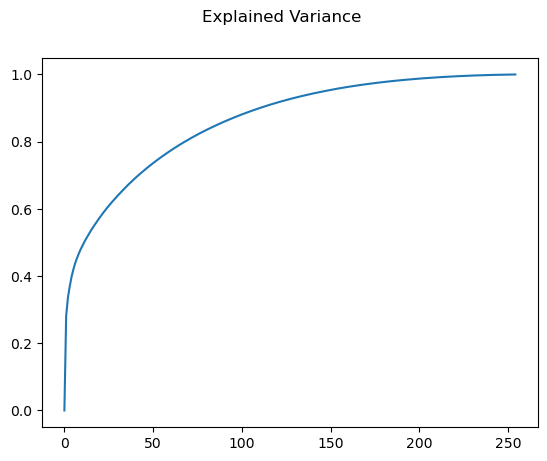

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
def pca_plot(df):
    scaled = StandardScaler().fit_transform(df)
    explained_variances = np.zeros(len(df.columns))
    for i in range(0, len(explained_variances)):
        pca = PCA(i)
        pca.fit(scaled)
        explained_variances[i] = sum(pca.explained_variance_ratio_)
    plt.plot(explained_variances)
plt.suptitle("Explained Variance")
pca_plot(clean)

Try 50-100 factors OR numerically decide

## Find Out / TODO
- Nonlinear: ReLU? Should be able to approximate any function w/enough layers but see if there's a reason to expect other activation functions to be more efficient
    - *or leaky ReLU? (doesn't saturate on left side)*
- When comparing networks TRAINED N steps ahead, confirm that we try to PREDICT the same # because N will be the same for train & test splits? *yes*
- For variable # steps ahead:
    - How many steps ahead is prediction? If doing inference on test split, will be unpredictable, but will there be a way to use it to control how many? Or is unpredictability not a problem for the intended use?
    - If the same input sequence maps to 2 different output sequences because those data points have 2 different N's, is this a problem? Will hinder accuracy if happens in test set but will it hinder learning if happens in training set?
    - *answer: we're not mapping input -> equal length output sequence, we're mapping input -> N equal-length output sequences where ith is i steps ahead*
- Verify input & output sequences consist of ONE time point EXACTLY N steps ahead? (except variable-length sequence where output is N of them)
  - Anything to be gained from using multiple time points as input? Takes advantage of what can be learned from their order
- How to avoid survivorship bias?
    - 0 for NaNs? (but edge case on day when company goes bust -> 100% negative returns?)
- When switching to daily, truncate to 2015-present

#### Citations

1. Idea and ongoing guidance provided by Cameron Fen
1. Brygalova, DeMiguel, Li, Pelger (2023) "Asset-Pricing Factors with Economic Targets"
1. WRDS data set: https://wrds-www.wharton.upenn.edu/